In [1]:
!pip install -q torch_snippets
!pip install -q torch_summary
from torch_snippets import *
from torchsummary import summary
import torchvision.models as models
import torchvision.transforms as T
import cv2, numpy as np
import pandas as pd
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 49 kB 3.8 MB/s 
     |████████████████████████████████| 60 kB 7.0 MB/s 
     |████████████████████████████████| 11.1 MB 50.2 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 948 kB 10.4 MB/s 
     |████████████████████████████████| 58 kB 4.5 MB/s 
     |████████████████████████████████| 232 kB 39.1 MB/s 
     |████████████████████████████████| 51 kB 5.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [2]:
# Download the dataset from Kaggle using the below code.
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d muratkokludataset/pistachio-image-dataset
!ls
!unzip pistachio-image-dataset.zip

Saving kaggle.json to kaggle.json
kaggle.json
 71% 19.0M/26.7M [00:00<00:00, 46.3MB/s]
100% 26.7M/26.7M [00:00<00:00, 50.2MB/s]
kaggle.json  pistachio-image-dataset.zip  sample_data
Archive:  pistachio-image-dataset.zip
  inflating: Pistachio_Image_Dataset/Pistachio_16_Features_Dataset/Pistachio_16_Features_Dataset.arff  
  inflating: Pistachio_Image_Dataset/Pistachio_16_Features_Dataset/Pistachio_16_Features_Dataset.xls  
  inflating: Pistachio_Image_Dataset/Pistachio_16_Features_Dataset/Pistachio_16_Features_Dataset.xlsx  
  inflating: Pistachio_Image_Dataset/Pistachio_16_Features_Dataset/Pistachio_16_Features_Dataset_Citation_Request.txt  
  inflating: Pistachio_Image_Dataset/Pistachio_28_Features_Dataset/Pistachio_28_Features_Dataset.arff  
  inflating: Pistachio_Image_Dataset/Pistachio_28_Features_Dataset/Pistachio_28_Features_Dataset.xls  
  inflating: Pistachio_Image_Dataset/Pistachio_28_Features_Dataset/Pistachio_28_Features_Dataset.xlsx  
  inflating: Pistachio_Image_Dataset/P

# **Dataset Construction**

In [3]:
from glob import glob
class Pistachio_DS(Dataset):
  def __init__(self,folder1,folder2):
    kirmizi = glob(folder1+"/*.jpg")
    siirt = glob(folder2+"/*.jpg")
    self.fpaths = kirmizi + siirt
    self.normalize = transforms.Normalize(mean=[0.485,0.456,0.406],
                                          std=[0.229,0.224,0.225])
    # Classify Kirmizi pistachio as 1 and the other as 0
    from random import shuffle, seed; seed(10)
    self.targets = [fpath.split('/')[-1].startswith('kirmizi') for fpath in self.fpaths]
  def __len__(self): return len(self.fpaths)
  def __getitem__(self,ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = cv2.imread(f)[:,:,::-1]
    im = cv2.resize(im,(224,224))
    im = torch.tensor(im/255)
    im = im.permute(2,0,1)
    im = self.normalize(im)
    return im.float().to(device), torch.tensor([target]).float().to(device)

kirmizi_dir = '/content/Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio'
siirt_dir = '/content/Pistachio_Image_Dataset/Pistachio_Image_Dataset/Siirt_Pistachio'



In [4]:
from torch.utils.data import random_split
dataset = Pistachio_DS(kirmizi_dir,siirt_dir)
trn_size = int(0.8*len(dataset)) # 80% for training
val_size = len(dataset) - trn_size # 20% for test

trn_ds, val_ds = random_split(dataset,[trn_size, val_size])
trn_loader = DataLoader(trn_ds,batch_size=11,shuffle=True)
val_loader = DataLoader(val_ds,batch_size=11,shuffle=False)

In [ ]:
print(len(trn_ds))
print(len(val_ds))

1718
430


# **Transfer Learning Model - VGG16**

In [5]:
def build_model():
  model = models.vgg16(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(2,4))
  model.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(4096,1024),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(1024,256),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(256,1),
      nn.Sigmoid()
  )
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
  return model.to(device), loss_fn, optimizer

model, loss_fn, optimizer = build_model()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [6]:
summary(model,input_size=(3,224,224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (1,792)
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       (36,928)
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       (73,856)
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       (147,584)
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      (295,168)
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      (590,080)
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      (590,080)
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      (1,180,160)
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (1,792)
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       (36,928)
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       (73,856)
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       (147,584)
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      (295,168)
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      (590,080)
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      (590,080)
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      (1,180,160)
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-

# **Training and Validating the Model**

In [7]:
def train_batch(img,target,model,loss_fn,optimizer):
  model.train()
  prediction = model(img)
  loss = loss_fn(prediction,target)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return loss

@torch.no_grad()
def accuracy(img,target,model):
  model.eval()
  prediction = model(img)
  acc = (prediction>0.5) == target
  return acc.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(img,target,model,loss_fn):
  prediction = model(img)
  val_loss = loss_fn(prediction,target)
  return val_loss

In [8]:
from torch.serialization import load
import numpy as np

train_accuracies, val_accuracies = [], []

log = Report(8)
for epoch in range(8):
  train_epoch_accuracies,  val_epoch_accuracies = [], []
  N = len(trn_loader)
  for ix, batch in enumerate(iter(trn_loader)):
    img, target = batch
    batch_loss = train_batch(img,target,model,loss_fn,optimizer)
    log.record(epoch+(ix+1)/N,trn_loss=batch_loss,end='\r')

  for ix, batch in enumerate(iter(trn_loader)):
    img, target = batch
    train_acc = accuracy(img,target,model)
    train_epoch_accuracies.extend(train_acc)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_loader)):
    img, target = batch
    test_loss = val_loss(img,target,model,loss_fn)
    log.record(epoch+(ix+1)/N,val_loss=test_loss, end='\r')

  for ix, batch in enumerate(iter(val_loader)):
    img, target = batch
    val_acc = accuracy(img,target,model)
    val_epoch_accuracies.extend(val_acc)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)
  
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)
  log.report_avgs(epoch+1)

EPOCH: 1.000	trn_loss: 0.274	val_loss: 0.098	(58.33s - 408.30s remaining)
EPOCH: 2.000	trn_loss: 0.093	val_loss: 0.183	(112.39s - 337.16s remaining)
EPOCH: 3.000	trn_loss: 0.069	val_loss: 0.066	(166.91s - 278.19s remaining)
EPOCH: 4.000	trn_loss: 0.042	val_loss: 0.056	(221.05s - 221.05s remaining)
EPOCH: 5.000	trn_loss: 0.043	val_loss: 0.050	(274.25s - 164.55s remaining)
EPOCH: 6.000	trn_loss: 0.020	val_loss: 0.053	(327.80s - 109.27s remaining)
EPOCH: 7.000	trn_loss: 0.018	val_loss: 0.048	(380.74s - 54.39s remaining)
EPOCH: 8.000	trn_loss: 0.014	val_loss: 0.047	(434.40s - 0.00s remaining)


100%|██████████| 109/109 [00:00<00:00, 1975.82it/s]


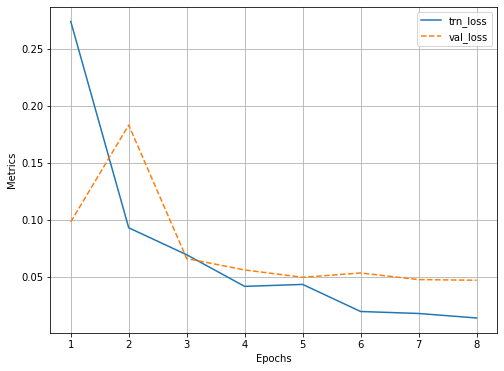

In [9]:
log.plot_epochs(['trn_loss','val_loss'])

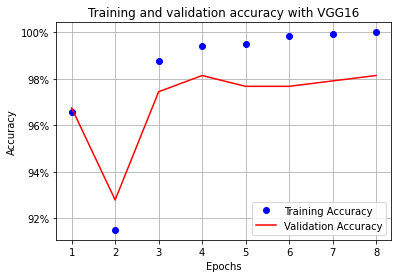

In [15]:
ㅔㅔepochs = np.arange(8)+1
import matplotlib.ticker as mticker
%matplotlib inline

plt.plot(epochs,train_accuracies,'bo',label='Training Accuracy')
plt.plot(epochs,val_accuracies,'r',label='Validation Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [11]:
print(max(train_accuracies))
print(max(val_accuracies))

1.0
0.9813953488372092


# **Confusion Matrix**

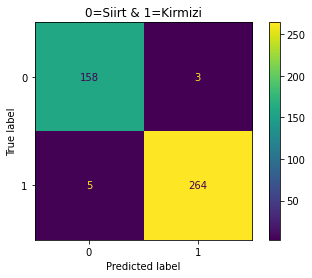

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd

target_pred = []
target_true = []

# iterate over test data
for img, target in val_loader:
        output = model(img) # Feed Network
        output = (output>0.5)
        output = output.data.cpu().numpy()
        target_pred.extend(output) # Save Prediction
        
        target = target.data.cpu().numpy()
        target_true.extend(target) # Save Truth

# constant for classes
classes = ('Kirmizi','Siirt')

# Build confusion matrix
cf_matrix = confusion_matrix(target_true, target_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()
plt.title("0=Siirt & 1=Kirmizi")
plt.show()

# **ROC Curve**

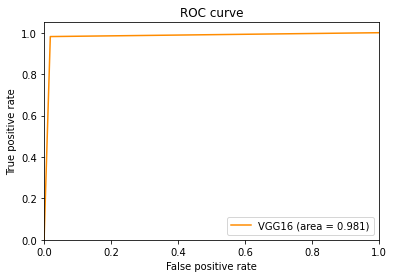

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(target_true, target_pred)
roc_auc = roc_auc_score(target_true, target_pred)

plt.figure(1)
lw = 2
plt.plot(fpr, tpr, color="darkorange", label="VGG16 (area = {:.3f})".format(roc_auc))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()